# Get Bio-ARGO data
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 21, 2025

>📘 Learning Objectives
>
> 1. Get [Argo data](https://www.aoml.noaa.gov/argo) using the [argopy](https://pypi.org/project/argopy/) Python package
> 2. Learn the basic format of the data grouped into platform and cycles
> 3. Learn how to filter to just surface data
> 4. Learn how to get data in batches

Biogeochemical Argo (“Bio-Argo” or BGC-Argo) floats are autonomous profiling instruments that drift with ocean currents and periodically dive from the surface to depths of 1,000–2,000 meters, collecting a vertical profile of physical and biogeochemical properties. These floats are all over the world's oceans and the data are freely available via the Argo global data assembly centers (GDACs) [Video on the Argo system](https://youtu.be/IixnxfysYAE?si=5xcPe6wa3LoWqUL3).

Each float has a unique PLATFORM_NUMBER, and every time it dives and returns to the surface it produces a new profile, identified by its CYCLE_NUMBER. A single float may produce hundreds of profiles over several years. Bio-Argo floats carry optical, chemical, and physical sensors that measure variables such as chlorophyll-a (CHLA), temperature (TEMP), salinity (PSAL), pressure (PRES, which is used as depth), dissolved oxygen (DOXY), and nitrate (NITRATE). These data are distributed in a consistent, profile-based format: each profile (platform+cycle) contains measurements at multiple depths, along with time, latitude, longitude, and quality-control flags. To use these data for surface-matching with satellite products, we will extract the shallow measurements from each profile (pressure is less than 20dbar or 10dbar). We will use the [argopy](https://pypi.org/project/argopy/) package to download Argo data from the [Coriolis Argo Global Assembly Center](https://coriolis-93c5db.gitlab-pages.ifremer.fr/).

![](Supporting_files/argo_float_cycle.png)

## Workflow

Here is our basic workflow.

1. Use `argopy` to fetch data for Bio-Argo profiles in a given region and time
3. For each profile, save one point, the shallowest reading.
4. Process the globe in monthly chunks to not overload the ERDDAP server and save the monthly shallow points to a parquet file.

In [2]:
!pip install argopy

## Step 1. Get some data

In this first step we’ll grab some in-situ data from Bio-Argo floats. We use `argopy`’s `ArgoDataFetcher` function to set up a datafetcher object with the information on what dataset (`ds` arg), where (`src` arg) and what parameters. We can access data by a specific buoy (platform), cycle (one descending/ascending cycle of a float), or by region (any data in that region, depth, time). We will use region. Once we set up our datafetcher object, we request the data using a method like `to_xarray()` or `to_dataframe()` to get the data and return in a specific form. We will use `to_xarray()` because the processing by buoy/cycle to get the shallowest points will be easier using xarray.

The code below requests only chlorophyll (CHLA) and pressure (PRES) for March 2024 in our chosen region and returns the result as an xarray Dataset that we can later save as a parquet file.

In [3]:
# get some data
from argopy import DataFetcher as ArgoDataFetcher
# specify the data set and what source
fetcher = ArgoDataFetcher(
    ds="bgc",
    src="erddap",
    params=["CHLA", "PRES"] # both these need to be present
)
# specify that we want to access data in a region; a NW Atlantic box
# lon_min, lon_max, lat_min, lat_max, depth_min, depth_max, time_min, time_max
region = [-70, -40, 20, 60, 0, 1000, "2024-03-01", "2024-04-01"]
fetcher = fetcher.region(region)
fetcher

<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-70.00/-40.00; y=20.00/60.00; z=0.0/1000.0; t=2024-03-01/2024-04-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['CHLA', 'PRES', 'TEMP', 'PSAL']
📕 BGC 'must be measured' parameters: []
🏊 User mode: standard
🟢 Dataset: bgc-s
🌥  Performances: cache=False, parallel=False

In [4]:
# Get the data using the to_xarray() method
ds_na = fetcher.to_xarray()

In [4]:
ds_na

<xarray.Dataset> Size: 1MB
Dimensions:          (N_POINTS: 9267)
Coordinates:
    LATITUDE         (N_POINTS) float64 74kB 27.53 35.76 23.02 ... 39.93 26.89
    LONGITUDE        (N_POINTS) float64 74kB -50.32 -56.92 ... -68.26 -50.2
    TIME             (N_POINTS) datetime64[ns] 74kB 2024-03-01T05:16:51.00099...
  * N_POINTS         (N_POINTS) int64 74kB 0 1 2 3 4 ... 9263 9264 9265 9266
Data variables: (12/21)
    CHLA             (N_POINTS) float32 37kB 0.0036 0.0036 ... 0.005341 0.0
    CHLA_DATA_MODE   (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA_ERROR       (N_POINTS) float32 37kB 0.0072 0.0072 0.02847 ... nan 0.0
    CHLA_QC          (N_POINTS) int64 74kB 1 1 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1
    CYCLE_NUMBER     (N_POINTS) int64 74kB 107 103 78 78 78 ... 21 21 21 21 110
    DIRECTION        (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...               ...
    PSAL_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 37kB 7.259 7.285 24.82 ... 4.812 7.062
    TEMP_DATA_MODE   (N_POINTS) <U1 37kB 'D' 'D' 'A' 'A' 'A' ... 'R' 'R' 'R' 'D'
    TEMP_ERROR       (N_POINTS) float32 37kB 0.002 0.002 nan ... nan nan 0.002
    TEMP_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           jovyan
    Fetched_date:         2025/11/28
    Fetched_constraints:  [x=-70.00/-40.00; y=20.00/60.00; z=0.0/1000.0; t=20...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [CHLA,PRES,PSAL,TEMP] real-time and adjusted/delaye...

In [5]:
# How many row in our dataframe?
df = ds_na.to_dataframe().reset_index()
df.shape[0]

9267

### Plot the data

/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


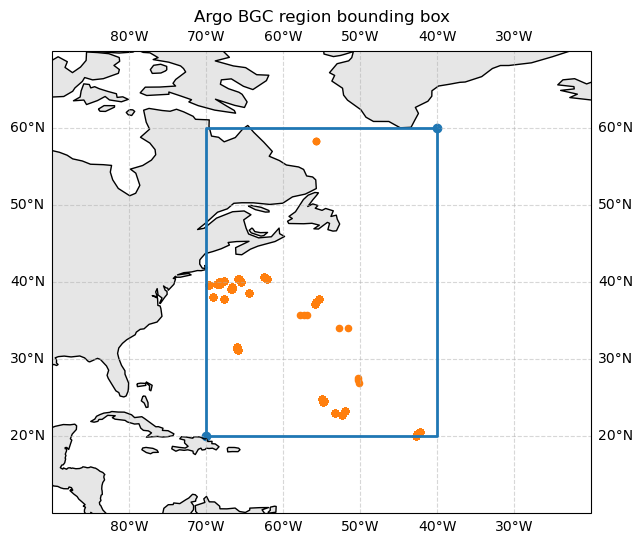

In [5]:
# plot the data; includes all buoys and all depths during each cycle
lon_min, lon_max, lat_min, lat_max = region[:4]
ds = ds_na

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Corners of the box (closed loop)
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Show a bit more context than just the box
ax.set_extent([lon_min - 20, lon_max + 20, lat_min - 10, lat_max + 10], crs=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot the bounding box
ax.plot(lons, lats, transform=proj, linewidth=2)
ax.scatter([lon_min, lon_max], [lat_min, lat_max], transform=proj)

# Add the Argo points from ds
ax.scatter(
    ds["LONGITUDE"].values,
    ds["LATITUDE"].values,
    s=20,
    marker="o",
    transform=proj,
)

ax.set_title("Argo BGC region bounding box")

plt.show()



### Profiles: a descending/ascending cycle

The data for each buoy are organized into cycles which is data collected on one descending/ascending cycle. Depending how the buoy is set up to record data, it might record only on the descending or ascending part of the cycle. The data that the ocean color satellites measure is just the surface. Even if there is high CHLA in deep water, the satellite does not "see" that. Thus we need to filter our cycle data from just the upper layer (< 20 m or so).

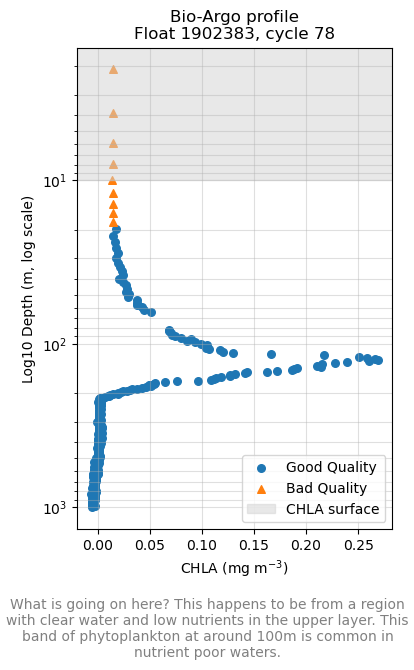

In [4]:
import numpy as np
import matplotlib.pyplot as plt

ds = ds_na  # just to keep the name short

# Unique platform numbers in the dataset
platforms = np.unique(ds["PLATFORM_NUMBER"].values)
plat = int(platforms[0])

# All cycles for that platform
cycles = ds["CYCLE_NUMBER"].where(ds["PLATFORM_NUMBER"] == plat, drop=True)
cycles = np.unique(cycles.values)
cyc = int(cycles[0])

# Select all points belonging to that profile
prof = ds.where(
    (ds["PLATFORM_NUMBER"] == plat) & (ds["CYCLE_NUMBER"] == cyc),
    drop=True
)

chl   = prof["CHLA"]
pres  = prof["PRES"]
qc = prof["CHLA_QC"]   # 'A' or 'D'

# Depth in meters ~ pressure in dbar
depth = pres
depth_plot = depth.clip(min=1)  # avoid 0 for log scale

# Masks for ascending/descending
good_mask =  qc.isin([1, 2])
bad_mask = ~good_mask

fig, ax = plt.subplots(figsize=(4, 6))

# Plot descending profile
ax.scatter(
    chl.where(good_mask),
    depth_plot.where(good_mask),
    label="Good Quality",
    s=30,
)

# Plot ascending profile
ax.scatter(
    chl.where(bad_mask),
    depth_plot.where(bad_mask),
    label="Bad Quality",
    s=30,
    marker="^",
)

# Add a shaded layer representing what is often designated as CHLA surface (e.g. 0–10 m)
z_sat = 10  # meters; adjust to taste for your explanation
ax.axhspan(0, z_sat, color="lightgrey", alpha=0.5,
           label="CHLA surface")

# Log scale on depth axis, surface at top
ax.set_yscale("log")
ax.invert_yaxis()

ax.set_xlabel("CHLA (mg m$^{-3}$)")
ax.set_ylabel("Log10 Depth (m, log scale)")
ax.set_title(f"Bio-Argo profile\nFloat {plat}, cycle {cyc}")
ax.grid(True, which="both", alpha=0.4)
ax.legend(loc="lower right")
plt.figtext(0.5, -0.1, "What is going on here? This happens to be from a region with clear water and low nutrients in the upper layer. This band of phytoplankton at around 100m is common in nutrient poor waters.",
            wrap=True, horizontalalignment='center', fontsize=10, color='gray')

# Adjust the bottom margin to make space for the annotation if necessary
#fig.subplots_adjust(bottom=0.25) # Increase bottom margin if annotation is cut off

plt.tight_layout()
plt.show()


## Step 2 Compute point estimates

We will compute two point estimates from the profiles of CHLA: 1) the surface average from 0 to 10m and 2) binned averages from 0 to 200m in bins 10m wide. We will not be filtering based on CHLA_QC so as to not lose too much data.

### Create functions to make these calculations from a profile

* `average_profile` takes the depth (`PRES`) and variable (`CHLA`) and gets the average over a depth range.
* `summarize_profile_binned` takes a filtered dataframe with just one profile (PLATFORM_NUMBER/CYCLE_NUMBER) and gives means for binned depths like 0 to 10m.

In [5]:
# average over a depth band
def average_profile(depth, var, z_min=0.0, z_max=None):
    """
    Average a var profile over a depth range.

    Parameters
    ----------
    depth : array-like
        1D array of depth or pressure (m or dbar ≈ m), increasing downward.
    var : array-like
        1D array of variable same shape as `depth`.
    z_min : float, optional
        Lower bound of depth (e.g. 0 for surface), in same units as depth.
    z_max : float or None, optional
        Upper bound of depth. If None, use max(depth).

    Returns
    -------
    Mean of var [z_min, z_max]. Returns np.nan if insufficient data.
    Number of data points in [z_min, z_max].
    """
    depth = np.asarray(depth, dtype=float)
    var   = np.asarray(var,   dtype=float)

    # Mask out NaNs
    m = np.isfinite(depth) & np.isfinite(var)
    depth = depth[m]
    var   = var[m]

    if depth.size < 1:
        return np.nan, 0

    # Set z_max if not provided
    if z_max is None:
        z_max = depth.max()

    # Subset to [z_min, z_max]
    sel = (depth > z_min) & (depth <= z_max)
    depth = depth[sel]
    var   = var[sel]

    if depth.size < 1:
        return np.nan, 0

    # Mean
    return np.mean(var), len(var)

In [6]:
# function to create our metrics for a platform/cycle group
import numpy as np
import pandas as pd

def summarize_profile_binned(group, var, depth_bins=None, include_meta=False):
    """
    Summarize a single Bio-Argo profile into depth-binned CHL means and one integrated bin.

    Parameters
    ----------
    group : dataframe
        dataframe with PRES, TIME, LATITUDE, LONGITUDE, var. Expected to be from
        filtering a Argo dataframe by PLATFORM_NUMBER and CYCLE_NUMBER
    var : str
        name of variable like `CHLA`.
    depth_bins : list, optional
        list of bins. Default is 0,10,...,200
    include_meta : Bool, optional
        whether to include TIME, LATITUDE, LONGITUDE in the returned dataframe

    Returns
    -------
    Returns pd.Series with one row with CHL in each depth bin + metadata (if include_meta=True)
    """
    depth_bins = np.arange(0, 210, 10)  # 0,10,...,200

    z = group["PRES"].values
    c = group[var].values

    out = {}

    if include_meta:# metadata
        out["TIME"]      = group["TIME"].iloc[0]
        out["LATITUDE"]  = group["LATITUDE"].iloc[0]
        out["LONGITUDE"] = group["LONGITUDE"].iloc[0]

    # depth-binned means
    for z0, z1 in zip(depth_bins[:-1], depth_bins[1:]):
        col1 = f"{var}_{int(z0)}_{int(z1)}"
        col2 = f"{var}_{int(z0)}_{int(z1)}_N"
        out[col1], out[col2] = average_profile(z, c, z_min=z0, z_max=z1)

    return pd.Series(out)

The `summarize_profile_binned` will return the depth binned averages for each profile.

In [13]:
# convert the xarray dataset from Argo to dataframe
df = ds_na.to_dataframe().reset_index()

# QC first if desired
df_qc = df[df["CHLA_QC"].isin([1, 2])]

# Get the binned averages and add on some metadata
df_points = (
    df_qc
    .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
    .apply(summarize_profile_binned, var="CHLA", include_meta=True, include_groups=False)   # default 0–200m in 10m bins
    .reset_index(drop=True)
)

In [14]:
df_points.head()

,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,CHLA_0_10,CHLA_0_10_N,CHLA_10_20,CHLA_10_20_N,CHLA_20_30,...,CHLA_150_160,CHLA_150_160_N,CHLA_160_170,CHLA_160_170_N,CHLA_170_180,CHLA_170_180_N,CHLA_180_190,CHLA_180_190_N,CHLA_190_200,CHLA_190_200_N
0,1902383,78,2024-03-02 16:13:24.002000128,23.0209,-53.2220,NaN,0,0.017404,1,0.016929,...,0.129163,5,0.101144,5,0.054446,5,0.042098,5,0.024844,5
1,1902383,79,2024-03-12 15:19:00.002000128,22.7279,-52.3932,0.011863,1,0.013578,6,0.012971,...,0.126472,5,0.095604,5,0.058087,5,0.041782,5,0.025952,5
2,1902383,80,2024-03-22 15:28:33.002000128,23.2649,-52.0005,NaN,0,0.023577,5,0.015662,...,0.065052,5,0.057928,5,0.062677,5,0.045739,5,0.027851,5
3,1902384,79,2024-03-08 20:58:18.002000128,20.0154,-42.7101,0.027295,5,0.028305,5,0.029748,...,0.136242,5,0.112432,5,0.074770,5,0.042880,5,0.028594,5
4,1902384,80,2024-03-18 20:31:41.002000128,20.3018,-42.5525,0.016256,4,0.018060,5,0.019359,...,0.201177,5,0.124553,5,0.078233,5,0.050095,5,0.037541,5


## Summary

Now you can query the Bio-Argo ERDDAP server and get Argo profiles for any region and time frame. You can filter the data by quality and get averages for different depths. 

Stop here is you just need to know how to get Bio-Argo data. In the next section, I show how I queried for the whole globe and assembled into monthly 10-20Mb netcdfs which I process into a 2Mb dataframe with rows for each profile (a single descend/ascend cycle for a buoy) with the binned CHLA averages. This dataframe is small enough to keep on GitHub with the tutorials. This has all profiles, CHLA data were not filtered by quality and CHLA for many depth bins, including surface, may be missing. You can load and plot this file as

In [5]:
# Load data from GitHub
import pandas as pd
url = "https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/CHLA_argo_profiles.parquet"
df = pd.read_parquet(url)
print(f"\nNumber of profiles in the dataset {len(df)}\n")
df.head()


Number of profiles in the dataset 15833



,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,CHLA_0_10,CHLA_0_10_N,CHLA_10_20,CHLA_10_20_N,CHLA_20_30,...,CHLA_150_160_N,CHLA_160_170,CHLA_160_170_N,CHLA_170_180,CHLA_170_180_N,CHLA_180_190,CHLA_180_190_N,CHLA_190_200,CHLA_190_200_N,profile_id
0,1902304,155,2024-03-01 21:23:16.002000128,54.6582,-19.2434,0.150386,4,0.158043,5,0.162104,...,5,0.158550,5,0.154490,5,0.153305,5,0.154151,5,1902304_0155
1,1902304,156,2024-03-11 20:45:53.002000128,54.9187,-18.9609,0.155674,4,0.156858,5,0.156520,...,5,0.135201,5,0.135539,5,0.136385,5,0.134524,5,1902304_0156
2,1902304,157,2024-03-21 21:21:39.002000128,55.2967,-18.8331,0.195647,4,0.202542,5,0.197805,...,5,0.200004,5,0.198820,5,0.194590,5,0.198651,5,1902304_0157
3,1902304,158,2024-03-31 21:31:53.002000128,55.7268,-18.8653,0.190783,4,0.193575,5,0.192052,...,5,0.153982,5,0.143492,5,0.135201,5,0.143830,5,1902304_0158
4,1902380,79,2024-03-07 18:01:17.002000128,17.6665,-46.0155,0.008062,4,0.009940,5,0.017452,...,5,0.066193,5,0.053091,5,0.043657,5,0.031253,5,1902380_0079


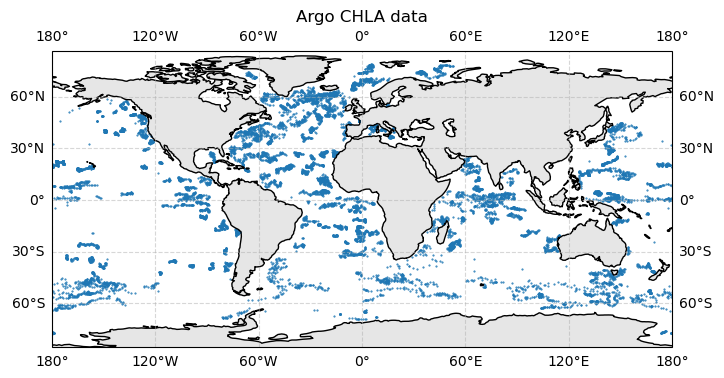

In [7]:
# plot the data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

df_clean = df.dropna(subset=["CHLA_0_10"])

# Add the Argo points from df
ax.scatter(
    df_clean["LONGITUDE"].values,
    df_clean["LATITUDE"].values,
    s=1,
    marker=".",
    transform=proj,
)

ax.set_title("Argo CHLA data")

plt.show()

Each dot is a profile (descend/ascend cycle for one buoy). Some regions are better represented that others.

---

**If you want to see how I assembled the global file, read below.**

# Process data from the whole globe

I will show 2 workflows. The first one gets Argo data and processes that into a dataframe with CHLA binned averages for each profile (descend/ascend cycle for a buoy). The dataframe has one row per Argo profile. Then these dataframes are assembled together into one parquet file for the whole globe. This problem with this is that if you change your mind regarding how to summarize the Argo data, then you have to query the Argo ERDDAP server again. If you are doing a lot of experimentation, then you keep hitting their server over and over (slow and excessive use of their server).  So in the second workflow, I saved 10-20Mb netcdfs for all Bio-Argo data for a month and then worked with that as I experimented with how to summarize the profile data (measurements at each depth).

## Workflow 1: Process into profile summaries directly

There are 3 steps, which take in total about 4 hours. 

1. Get profile summaries for a region and month. To do this create the function `get_bgc_profile()`. This will fetch profile Bio-Argo data for a region and month and save as parquet. Returns dataframe with one row per profile (a descend/ascend cycle for a buoy) with the whole CHLA binned profile (averages for different depth bins). Uses our `summarize_profile_binned()` function from above.
2. A for loop to work through the whole globe and save the monthly parquet files. This is the step that takes 4 hrs.
3. Merge these files altogether into one file to put on GitHub.

### A function to get one month `get_bgc_profile()`

Get a month for a region. Return a dataframe of the shallow points only. The function allows us to get multiple possible variables like CHLA, DOXY, NITRATE, BBP770, TEMP and PSAL. However if we pass in multiple variables then all must be present, so to maximize the data only pass in one varible at a time unless you need paired measurements.

In [232]:
# get_bgc_profile() function
from pathlib import Path

import numpy as np
import pandas as pd
from argopy import DataFetcher as ArgoDataFetcher


def get_bgc_profile(reg, mon, data_dir="data", vars=None, save=False):
    """
    Fetch profile Bio-Argo data for a region and month and (optionally) save as parquet.
    Returns dataframe with one row per profile (a descend/ascend cycle for a buoy)
    with the whole CHLA binned profile (averages for different depth bins).

    Parameters
    ----------
    reg : sequence
        [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
        (same as argopy region, but without time bounds).
    mon : str or datetime-like
        Month to fetch, e.g. "2024-03" or "2024-03-01".
    data_dir : str, optional
        Directory where the parquet file will be saved.
    vars : list of str, optional
        Bio-Argo variables to fetch and surface-average (e.g. ["CHLA", "BBP700", "DOXY"]).
        Defaults to ["CHLA"].
    save : bool, optional
        If True, save a parquet file and return (df_surf, path).
        If False, just return (df_surf, None).

    Returns
    -------
    df_surf : pandas.DataFrame
        Near-surface samples (one row per profile) with requested variables.
    out_path : str or None
        Path to the saved parquet file, or None if save=False.
    """
    if vars is None:
        vars = ["CHLA"]  # default behaviour

    # Required base columns in the data from Bio-Argo
    base_cols = [
        "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE", "PRES",
    ]

    # De-duplicate and drop any that are base columns (e.g. PRES)
    extra_vars_raw = list(dict.fromkeys(vars))
    extra_vars = [v for v in extra_vars_raw if v not in base_cols]

    def extra_cols(var):
        depth_bins = np.arange(0, 210, 10)  # 0,10,...,200
        cols = []
        for v in var:
            cols.append(f"{v}_INT_150")
            for z0, z1 in zip(depth_bins[:-1], depth_bins[1:]):
                cols.append(f"{v}_{int(z0)}_{int(z1)}")
        return cols
    # column names of the metrics, like CHLA_0_10
    var_metric_cols = extra_cols(extra_vars)

    # Columns that we need for processing the argo data
    argo_cols = base_cols + extra_vars
    # Final schema for the output DataFrame: base - PRES + colnames of points (like CHLA_INT_150)
    final_cols = base_cols + var_metric_cols 
    final_cols.remove("PRES");

    lon_min, lon_max, lat_min, lat_max, z_min, z_max = reg

    # Compute start/end of the month
    mon_start = pd.to_datetime(mon).to_period("M").start_time
    mon_end = (mon_start + pd.offsets.MonthBegin(1))

    region = [
        lon_min, lon_max,
        lat_min, lat_max,
        z_min, z_max,
        mon_start.strftime("%Y-%m-%d"),
        mon_end.strftime("%Y-%m-%d"),
    ]

    # STEP 1: Get data for region + month
    # We always request PRES, plus user extras (not TEMP/PSAL unless user asked)
    param_vars = list(dict.fromkeys(extra_vars + ["PRES"]))

    fetcher = ArgoDataFetcher(
        ds="bgc",
        src="erddap",
        params=param_vars,
    )

    try:
        ds = fetcher.region(region).to_xarray()
    except Exception as exc:
        print(f"No data for region={reg}, month={mon}: {exc}")
        # Return empty frame with full schema
        return pd.DataFrame(columns=final_cols), None

    # Bail if argopy returned an empty ds
    if "N_POINTS" in ds.sizes and ds.sizes["N_POINTS"] == 0:
        print(f"No data rows (N_POINTS=0) for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None
    
    # Also guard against “all dims zero”
    if all(size == 0 for size in ds.sizes.values()):
        print(f"No data rows (all dims zero) for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None    
        
    # STEP 2: Compute point metrics
    ds_vars = set(ds.data_vars) | set(ds.coords)

    # We only select columns that exist, but we *remember* full schema in argo_cols
    qc_cols = [f"{v}_QC" for v in extra_vars if f"{v}_QC" in ds_vars]
    available_cols = [c for c in argo_cols if c in ds_vars] + qc_cols
    available_cols = list(dict.fromkeys(available_cols))  # de-dup

    if not available_cols:
        print(f"No requested columns in dataset for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None
        
    df_all = ds[available_cols].to_dataframe().reset_index(drop=True)

    if df_all.empty:
        print(f"No data rows for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None

    # Ensure all required base columns are present before aggregating
    missing_base = [c for c in base_cols if c not in df_all.columns]
    if missing_base:
        raise ValueError(
            f"Missing required base columns {missing_base} in argo data "
            f"for region={reg}, month={mon}"
        )

    df_clean = df_all.copy()

    # STEP 2a: Base per-profile aggregation
    agg_dict = {
        "TIME": ("TIME", "first"),
        "LATITUDE": ("LATITUDE", "first"),
        "LONGITUDE": ("LONGITUDE", "first"),
    }

    df_points = (
        df_clean
        .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
        .agg(**agg_dict)
    )

    # STEP 2b: per-variable metrics (using QC if available)
    for v in extra_vars:
        if v not in df_clean.columns:
            # We will add it later as NaN for schema consistency
            continue

        df_var = df_clean.copy()
        qc_col = f"{v}_QC"
        # If a QC column exists, filter by good values
        if qc_col in df_var.columns:
            df_var = df_var[df_var[qc_col].isin([1, 2])]

        if df_var.empty:
            # no good data for this variable; we'll add NaNs later
            continue

        df_points_var = (
            df_var
            .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
            .apply(summarize_profile_binned, var=v, include_groups=False)   # default 0–200m in 10m bins
        )

        df_points = df_points.merge(
            df_points_var,
            on=["PLATFORM_NUMBER", "CYCLE_NUMBER"],
            how="left",
        )

    # STEP 2c: ensure all extras exist as columns (NaN if no data)
    for v in var_metric_cols :
        if v not in df_points.columns:
            df_points[v] = np.nan

    # Sanity check: all cols in final_cols must exist now
    missing_base_final = [c for c in final_cols if c not in df_points.columns]
    if missing_base_final:
        raise ValueError(
            f"After aggregation, missing base columns {missing_base_final} in df_points "
            f"for region={reg}, month={mon}"
        )

    # Reorder columns to match target schema exactly
    df_points = df_points.reindex(columns=final_cols)

    # STEP 3: Save to parquet in data/ dir (optional)
    data_path = Path(data_dir)
    data_path.mkdir(parents=True, exist_ok=True)

    out_fname = (
        f"argo_bgc_{lat_min}_{lat_max}_{lon_min}_{lon_max}_"
        f"{mon_start.strftime('%Y%m')}.parquet"
    )
    out_path = data_path / out_fname

    if save:
        df_points.to_parquet(out_path, index=False)
        return df_points, str(out_path)

    return df_points, None
    

In [234]:
%%time
# Example
params = ["CHLA"]
# [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
region = [-55, -50, 20, 25, 0, 200]
month = "2024-03"
df_surf, _ = get_bgc_profile(region, month, vars=params)
df_surf.head()

CPU times: user 2.9 s, sys: 94.8 ms, total: 3 s
Wall time: 8.05 s


,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,CHLA_INT_150,CHLA_0_10,CHLA_10_20,CHLA_20_30,CHLA_30_40,...,CHLA_100_110,CHLA_110_120,CHLA_120_130,CHLA_130_140,CHLA_140_150,CHLA_150_160,CHLA_160_170,CHLA_170_180,CHLA_180_190,CHLA_190_200
0,1902383,78,2024-03-02 16:13:24.002000128,23.0209,-53.2220,0.085970,NaN,0.017404,0.016929,0.021678,...,0.107001,0.176812,0.258653,0.211954,0.170480,0.129163,0.101144,0.054446,0.042098,0.024844
1,1902383,79,2024-03-12 15:19:00.002000128,22.7279,-52.3932,0.109202,0.011863,0.013578,0.012971,0.017404,...,0.293004,0.237599,0.196283,0.168263,0.160982,0.126472,0.095604,0.058087,0.041782,0.025952
2,1902383,80,2024-03-22 15:28:33.002000128,23.2649,-52.0005,0.087394,NaN,0.023577,0.015662,0.018353,...,NaN,0.288097,0.201032,0.145627,0.105102,0.065052,0.057928,0.062677,0.045739,0.027851
3,1902385,78,2024-03-04 07:40:06.000999936,24.4592,-54.8044,0.075974,0.026190,0.026150,0.026465,0.025993,...,0.080926,0.139006,0.220854,0.195828,0.165449,0.120276,0.062982,0.037483,0.022845,0.010410
4,1902385,79,2024-03-14 09:51:52.000999936,24.5896,-54.7481,0.076172,NaN,NaN,NaN,0.023632,...,0.104378,0.171273,0.229354,0.190161,0.136803,0.106267,0.067389,0.045511,0.027724,0.013716


In [216]:
df_surf.columns

Index(['PLATFORM_NUMBER', 'CYCLE_NUMBER', 'TIME', 'LATITUDE', 'LONGITUDE',
       'CHLA_INT_150', 'CHLA_0_10', 'CHLA_10_20', 'CHLA_20_30', 'CHLA_30_40',
       'CHLA_40_50', 'CHLA_50_60', 'CHLA_60_70', 'CHLA_70_80', 'CHLA_80_90',
       'CHLA_90_100', 'CHLA_100_110', 'CHLA_110_120', 'CHLA_120_130',
       'CHLA_130_140', 'CHLA_140_150', 'CHLA_150_160', 'CHLA_160_170',
       'CHLA_170_180', 'CHLA_180_190', 'CHLA_190_200'],
      dtype='object')

### A for loop to work through the whole globe

Loop through the globe and save monthly files. We will do this for all months when there is PACE data. This will take about four hours but we only have to do it once. The `%%script` false is added to prevent accidentally run the cell.

In [ ]:
%%script false --no-raise-error
# comment out the above to run; this just prevents inadvertant running
# since this loops through the whole globe
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Variables to get if avail. NaN if missing
BGC_VARS = ["CHLA"]
out_dir = Path("_temp_data/chla_profile")
out_dir.mkdir(parents=True, exist_ok=True)

# Months from 2024-03 up to the current month
start_month = "2024-03"
end_month = pd.Timestamp.today().to_period("M")
months = pd.period_range(start_month, end_month, freq="M")

for mon in months:
    month_str = mon.strftime("%Y-%m")
    out_path = out_dir / f"argo_bgc_global_{month_str}.parquet"

    # Skip if we already have this month (so reruns don't redo everything)
    if out_path.exists():
        print(f"Skipping {month_str}, already have {out_path}")
        continue

    print(f"\n=== Processing month {month_str} ===")

    dfs = []  # collect all boxes for this month

    # Latitude: 45° bands from -90 to 90 -> 4 bands
    for lat_min in range(-90, 90, 45):
        lat_max = lat_min + 45

        # Longitude: 60° bands from -180 to 180 -> 6 bands
        for lon_min in range(-180, 180, 60):
            lon_max = lon_min + 60
            region = [lon_min, lon_max, lat_min, lat_max, 0, 200]
            #print(f" -- region={region}")
            df_box, _ = get_bgc_profile(region, month_str, vars=BGC_VARS, save=False)
            if df_box is None or df_box.empty: continue
            dfs.append(df_box)

    # Desired column order (core metadata + all BGC vars)
    cols = [
        'profile_id', 'PLATFORM_NUMBER', 'CYCLE_NUMBER', 
        'TIME', 'LATITUDE', 'LONGITUDE',
       'CHLA_0_10', 'CHLA_10_20', 'CHLA_20_30', 'CHLA_30_40',
       'CHLA_40_50', 'CHLA_50_60', 'CHLA_60_70', 'CHLA_70_80', 'CHLA_80_90',
       'CHLA_90_100', 'CHLA_100_110', 'CHLA_110_120', 'CHLA_120_130',
       'CHLA_130_140', 'CHLA_140_150', 'CHLA_150_160', 'CHLA_160_170',
       'CHLA_170_180', 'CHLA_180_190', 'CHLA_190_200', 
    ]

    if not dfs:
        print(f"No data at all for month {month_str}, writing empty file")
        df_month = pd.DataFrame(columns=cols)
    else:
        df_month = pd.concat(dfs, ignore_index=True)

        # Make sure all expected columns exist; if missing, add as NaN
        # Create a stable profile_id: e.g. "6901234_0042"
        if "profile_id" not in df_month.columns:
            df_month["profile_id"] = (
                df_month["PLATFORM_NUMBER"].astype(int).astype(str).str.zfill(7)
                + "_"
                + df_month["CYCLE_NUMBER"].astype(int).astype(str).str.zfill(4)
            )

        for c in cols:
            if c not in df_month.columns:
                df_month[c] = np.nan

        # Now safely reorder columns
        df_month = df_month[cols]

    # Save one file per month
    df_month.to_parquet(out_path, index=False)
    print(f"Saved {len(df_month)} rows for {month_str} to {out_path}")

## Merge all monthly files together into one parquet

In [ ]:
%%script false --no-raise-error
# requires above to have run
# example of one monthly file
from pathlib import Path
import numpy as np
import pandas as pd

var_dir = Path("_temp_data/chla_profile")
# these are monthly files
files = sorted(var_dir.glob("argo_bgc_global_*.parquet"))
df = pd.read_parquet(files[0])
df.head()

In [236]:
# function to process the monthly files
from pathlib import Path
import numpy as np
import pandas as pd

def merge_bgc_monthlies(var_dir, out_path):
    """
    Merge monthly Bio-Argo parquet files for a single variable (e.g., CHLA or BBP700).

    Parameters
    ----------
    var_dir : str or Path
        Directory containing monthly parquet files like 'argo_bgc_global_YYYY-MM.parquet'.
    out_path : str or Path
        Output parquet path for the merged dataset.
    """
    var_dir = Path(var_dir)
    files = sorted(var_dir.glob("argo_bgc_global_*.parquet"))

    if not files:
        raise FileNotFoundError(f"No parquet files found in {var_dir}")

    dfs = []
    for f in files:
        print(f"Reading {f}")
        df = pd.read_parquet(f)
        dfs.append(df)

    # Concatenate all months
    df_all = pd.concat(dfs, ignore_index=True)

    # Save merged parquet
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_parquet(out_path, index=False)
    print(f"Saved merged dataset with {len(df_all)} rows to {out_path}")


In [ ]:
%%script false --no-raise-error
# requires above to have run
# %%script to prevent accidentally rerunning this code
outfile = "_temp_data/argo_bgc_global_profile_CHLA.parquet"
merge_bgc_monthlies("_temp_data/chla_profile", outfile)

Once you have the data file on your computer, you load as below. 

In [241]:
%%script false --no-raise-error
# Example. Requires above to have run
# Load from local file
from pathlib import Path
import numpy as np
import pandas as pd

file = "_temp_data/argo_bgc_global_profile_CHLA.parquet"
df = pd.read_parquet(file)

## Workflow 2: Save full Argo data queries first

**This is what I actually did** after discovering that I kept changing my mind about how to summarize the profile data; bin averages? only surface? how to define surface? how much QC to do? integrate by depth? etc, etc. 

There are 3 steps, which take in total about 4 hours. 

1. Using a for loop, save region/month files from a Argo query using `get_bgc_file()` for the whole globe. These files are small but I wanted to save since the ERDDAP server or my network would sometimes hang.
2. Merge these region/month files into monthly files and delete the region/month files since I won't need them anymore. I will keep the monthly files.
3. Get profile summaries for a region and month. To do this create the function `get_bgc_profile()`. This will fetch profile Bio-Argo data for a region and month and save as parquet. Returns dataframe with one row per profile (a descend/ascend cycle for a buoy) with the whole CHLA binned profile (averages for different depth bins). Uses our `summarize_profile_binned()` function from above.
4. A for loop to work through the whole globe and save the monthly parquet files. This is the step that takes 4 hrs.
5. Merge these files altogether into one file to put on GitHub.

### Save query file as netcdf `get_bgc_file()`

In [2]:
# get_bgc_surface() function
from pathlib import Path

import numpy as np
import pandas as pd
from argopy import DataFetcher as ArgoDataFetcher

def get_bgc_file(reg, mon, data_dir="data", vars=None, save=False):
    """
    Fetch profile Bio-Argo dataset.
    """
    if vars is None:
        vars = ["CHLA"]  # default behaviour

    # Required base columns in the data from Bio-Argo
    base_cols = [
        "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE", "PRES",
    ]

    # De-duplicate and drop any that are base columns (e.g. PRES)
    extra_vars_raw = list(dict.fromkeys(vars))
    extra_vars = [v for v in extra_vars_raw if v not in base_cols]

    lon_min, lon_max, lat_min, lat_max, z_min, z_max = reg

    # Compute start/end of the month
    mon_start = pd.to_datetime(mon).to_period("M").start_time
    mon_end = (mon_start + pd.offsets.MonthBegin(1))

    region = [
        lon_min, lon_max,
        lat_min, lat_max,
        z_min, z_max,
        mon_start.strftime("%Y-%m-%d"),
        mon_end.strftime("%Y-%m-%d"),
    ]

    # STEP 1: Get data for region + month
    # We always request PRES, plus user extras (not TEMP/PSAL unless user asked)
    param_vars = list(dict.fromkeys(extra_vars + ["PRES"]))

    fetcher = ArgoDataFetcher(
        ds="bgc",
        src="erddap",
        params=param_vars,
    )

    try:
        ds = fetcher.region(region).to_xarray()
    except Exception as exc:
        print(f"No data for region={reg}, month={mon}: {exc}")
        # Return empty frame with full schema
        return None

    # Bail if argopy returned an empty ds
    if "N_POINTS" in ds.sizes and ds.sizes["N_POINTS"] == 0:
        print(f"No data rows (N_POINTS=0) for region={reg}, month={mon}")
        return None
    
    # Also guard against “all dims zero”
    if all(size == 0 for size in ds.sizes.values()):
        print(f"No data rows (all dims zero) for region={reg}, month={mon}")
        return None    

    return ds
    

### For loop to get files for each month

Break the globe up into regions and get file for each region/month.

In [ ]:
%%script false --no-raise-error
# Save the raw files so I don't need to keep hitting the erddap server
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Variables to get if avail. NaN if missing
BGC_VARS = ["CHLA"]
out_dir = Path("_temp_data/raw")
out_dir.mkdir(parents=True, exist_ok=True)

# Months from 2024-03 up to the current month
start_month = "2024-03"
end_month = pd.Timestamp.today().to_period("M")
months = pd.period_range(start_month, end_month, freq="M")

for mon in months:
    month_str = mon.strftime("%Y-%m")

    print(f"\n=== Processing month {month_str} ===")

    dfs = []  # collect all boxes for this month

    # Latitude: 45° bands from -90 to 90 -> 4 bands
    for lat_min in range(-90, 90, 45):
        lat_max = lat_min + 45

        # Longitude: 60° bands from -180 to 180 -> 6 bands
        for lon_min in range(-180, 180, 60):
            lon_max = lon_min + 60
            region = [lon_min, lon_max, lat_min, lat_max, 0, 200]
            print(f" -- region={region}")
            ds_box = get_bgc_file(region, month_str, vars=BGC_VARS, save=False)
            if ds_box is None: continue
            out_path = out_dir / f"argo_bgc_global_{month_str}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.parquet"
            # Skip if we already have this month (so reruns don't redo everything)
            if out_path.exists():
                print(f"Skipping {month_str}, already have {out_path}")
                continue

            ds_box.to_netcdf(out_path)


### Merge the region/month files into one month file

In [ ]:
%%script false --no-raise-error
# Merge into monthly files for GitHub

from pathlib import Path
import pandas as pd
import xarray as xr

raw_dir = Path("_temp_data/raw")          # where the tile .nc files live
out_dir = Path("_temp_data/CHLA_argo_monthly_nc")   # where you want monthly merged .nc
out_dir.mkdir(parents=True, exist_ok=True)

# derive months from existing files
months = sorted({
    f.name.split("_")[3]           # "2024-03" from "argo_bgc_global_2024-03_..."
    for f in raw_dir.glob("argo_bgc_global_*.nc")
})

for month_str in months:
    out_path = out_dir / f"argo_bgc_global_{month_str}.nc"
    if out_path.exists():
        print(f"Skipping {month_str}, already have {out_path}")
        continue

    month_files = sorted(raw_dir.glob(f"argo_bgc_global_{month_str}_*.nc"))
    if not month_files:
        print(f"No tiles found for {month_str}, skipping")
        continue

    print(f"\n=== Merging {len(month_files)} tiles for {month_str} ===")

    # Peek at first file to find the "point" dimension (usually N_POINTS)
    with xr.open_dataset(month_files[0]) as ds0:
        # Prefer N_POINTS if present, otherwise just take the first non-time dim
        if "N_POINTS" in ds0.dims:
            point_dim = "N_POINTS"
        else:
            # fall back: pick first dimension that's not time
            non_time_dims = [d for d in ds0.dims if d.lower() != "time"]
            if not non_time_dims:
                raise ValueError(f"Could not figure out point dim for {month_files[0]}")
            point_dim = non_time_dims[0]

    # Open & concatenate all tiles along the point dimension
    ds_month = xr.open_mfdataset(
        month_files,
        combine="nested",
        concat_dim=point_dim,
        parallel=False,
    )

    # (Optional) sort by time then index if you like
    if "TIME" in ds_month:
        ds_month = ds_month.sortby("TIME")

    ds_month.to_netcdf(out_path)
    ds_month.close()

    print(f"  -> Saved merged monthly file to {out_path}")


In [21]:
# test
import xarray as xr
ds = xr.open_dataset("_temp_data/CHLA_argo_monthly_nc/argo_bgc_global_2024-12.nc")
ds

<xarray.Dataset> Size: 6MB
Dimensions:          (N_POINTS: 39413)
Coordinates:
    LATITUDE         (N_POINTS) float64 315kB ...
    LONGITUDE        (N_POINTS) float64 315kB ...
    TIME             (N_POINTS) datetime64[ns] 315kB ...
  * N_POINTS         (N_POINTS) int64 315kB 0 0 1 2 3 ... 6664 6665 6666 6667
Data variables: (12/21)
    CHLA             (N_POINTS) float32 158kB ...
    CHLA_DATA_MODE   (N_POINTS) <U1 158kB ...
    CHLA_ERROR       (N_POINTS) float32 158kB ...
    CHLA_QC          (N_POINTS) int64 315kB ...
    CYCLE_NUMBER     (N_POINTS) int64 315kB ...
    DIRECTION        (N_POINTS) <U1 158kB ...
    ...               ...
    PSAL_QC          (N_POINTS) int64 315kB ...
    TEMP             (N_POINTS) float32 158kB ...
    TEMP_DATA_MODE   (N_POINTS) <U1 158kB ...
    TEMP_ERROR       (N_POINTS) float32 158kB ...
    TEMP_QC          (N_POINTS) int64 315kB ...
    TIME_QC          (N_POINTS) int64 315kB ...
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           jovyan
    Fetched_date:         2025/11/29
    Fetched_constraints:  [x=-120.00/-60.00; y=-45.00/0.00; z=0.0/200.0; t=20...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [CHLA,PRES,PSAL,TEMP] real-time and adjusted/delaye...

### Create an index file with just the profile meta data

We will use this for doing matchups so we don't have to load more data than needed, e.g. all the profile data.

In [1]:
%%script false --no-raise-error
from pathlib import Path
import xarray as xr
import pandas as pd

var_dir = Path("_temp_data/CHLA_argo_monthly_nc")
files = sorted(var_dir.glob("argo_bgc_global_*.nc"))

profile_rows = []

for f in files:
    print(f"Reading {f}")
    ds = xr.open_dataset(f)

    # Select only the columns we need for the profile index
    needed = ["PLATFORM_NUMBER", "CYCLE_NUMBER", "TIME", "LATITUDE", "LONGITUDE", "CHLA_QC", "PRES"]
    missing = [v for v in needed if v not in ds.variables and v not in ds.coords]
    if missing:
        raise ValueError(f"{f} missing required vars: {missing}")

    df = (
        ds[needed]
        .to_dataframe()
        .reset_index(drop=True)
    )

    # Drop any rows without platform/cycle info
    df = df.dropna(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])

    # Collapse to ONE row per (PLATFORM_NUMBER, CYCLE_NUMBER).
    # We just keep:
    #   - TIME: first
    #   - LAT/LON: first (typically constant within profile)
    df_profiles = (
        df
        .sort_values("TIME")  # just to make "first" deterministic
        .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
        .agg({
            "TIME": "first",
            "LATITUDE": "first",
            "LONGITUDE": "first",
        })
    )

    profile_rows.append(df_profiles)

# Combine all months
profiles = pd.concat(profile_rows, ignore_index=True)

# If there is overlap between months, enforce uniqueness
profiles = (
    profiles
    .sort_values("TIME")
    .drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"], keep="first")
    .reset_index(drop=True)
)

# Create a stable profile_id: e.g. "6901234_0042"
profiles["profile_id"] = (
    profiles["PLATFORM_NUMBER"].astype(int).astype(str).str.zfill(7)
    + "_"
    + profiles["CYCLE_NUMBER"].astype(int).astype(str).str.zfill(4)
)

# Reorder columns: profile_id first, then metadata
profiles = profiles[
    ["profile_id", "PLATFORM_NUMBER", "CYCLE_NUMBER", "TIME",
     "LATITUDE", "LONGITUDE"]
]

print(len(profiles), "unique profiles")
print(profiles.columns)

# Save for later joins
out_path = var_dir / "argo_profiles_index.parquet"
profiles.to_parquet(out_path, index=False)
print("Wrote", out_path)

## Process the monthly files

Now that I have the data locally, we can easily create different metrics. Specifically, I will create the profile dataframe with CHLA binned depth averages for each profile. To do this, I run through all the months and create a list with dataframes from each month. Then I concatenate that into one dataframe with all the months. This is the final dataframe for GitHub. It is about 2.2Mb.

In [ ]:
# Example of doing this for one month file
import xarray as xr
ds = xr.open_dataset("_temp_data/CHLA_argo_monthly_nc/argo_bgc_global_2025-07.nc")

df = ds.to_dataframe().reset_index()

# QC first
#df_qc = df[df["CHLA_QC"].isin([1, 2])]

df_points = (
    df
    .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
    .apply(summarize_profile_binned, var="CHLA", include_meta=True, include_groups=False)   # default 0–200m in 10m bins
    .reset_index(drop=True)
)
df_points.shape

In [8]:
# Run through all the months and create a list with dataframes from each month
from pathlib import Path
import xarray as xr

var_dir = Path("_temp_data/CHLA_argo_monthly_nc")
files = sorted(var_dir.glob("argo_bgc_global_*.nc"))

profile_rows = []

for f in files:
    print(f"Reading {f}")
    ds = xr.open_dataset(f)
    df = ds.to_dataframe().reset_index()

    df_profiles = (
        df
        .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
        .apply(summarize_profile_binned, var="CHLA", include_meta=True, include_groups=False)   # default 0–200m in 10m bins
        .reset_index(drop=True)
    )
    profile_rows.append(df_profiles)

Reading data/argo_monthly_nc/argo_bgc_global_2024-03.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-04.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-05.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-06.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-07.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-08.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-09.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-10.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-11.nc
Reading data/argo_monthly_nc/argo_bgc_global_2024-12.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-01.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-02.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-03.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-04.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-05.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-06.nc
Reading data/argo_monthly_nc/argo_bgc_global_2025-07.nc
Reading data/argo_monthly_nc/argo_bgc_global_202

In [ ]:
# Merge the list of dataframes
profiles = pd.concat(profile_rows, ignore_index=True)
# Create a stable profile_id: e.g. "6901234_0042"
profiles["profile_id"] = (
    profiles["PLATFORM_NUMBER"].astype(int).astype(str).str.zfill(7)
    + "_"
    + profiles["CYCLE_NUMBER"].astype(int).astype(str).str.zfill(4)
)
# move profile_id to the start instead of the end
col = "profile_id"
profiles = profiles[[col] + [c for c in profiles.columns if c != col]]

## Save the final version with metadata

Use `pyarrow` package to add metadata. Adding thorough metadata when we are all done helps us know exactly how this parquet file was created.

In [27]:
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime

df = profiles

table = pa.Table.from_pandas(df)

file_meta = {
    "title": "Global Bio-Argo CHLA profile metrics (0 to 200 m, 10 m bins)",
    "creator": "Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393",
    "created": datetime.utcnow().isoformat() + "Z",
    "source": "BGC-Argo (via argopy). Argo (2000). Argo float data and metadata from Global Data Assembly Centre (Argo GDAC). SEANOE. https://doi.org/10.17882/42182",
    "description": (
        "All BGC-Argo data Mar 2024 to Nov 2025 with CHLA variable was downloaded."
        " Per-profile depth-binned CHLA means (0–200 m by 10 m bins) computed for each depth bin."
        " No QC filtering on the values was done using the CHLA_QC variable."
        " All profiles kept even if some binned averages were missing."
    ),
    "profile_id_definition": "profile_id = PLATFORM_NUMBER (7 digits) + '_' + CYCLE_NUMBER (4 digits)",
    "PLATFORM_NUMBER_definition": "PLATFORM_NUMBER from BGC-Argo identifying the buoy.",
    "CYCLE_NUMBER_definition": "CYCLE_NUMBER from BGC-Argo identifying the ascent/descent cycle.",
    "TIME_definition": "TIME in UTC from BGC-Argo. One time is assigned to each ascent/descent cycle.",
    "LATITUDE_definition": "LATITUDE from BGC-Argo. One is assigned to each ascent/descent cycle.",
    "LONGITUDE_definition": "LONGITUDE from BGC-Argo. One is assigned to each ascent/descent cycle.",
    "CHLA_A_B_definition": (
        "Depth binned averages of CHLA. Computed as the average of all individual CHLA measurements within the pressure interval "
        "(PRES>=A and PRES<B), where PRES is dbar and signifies depth."
        "No QC done on the CHLA data before averaging."
    ),
    "CHLA_A_B_N_definition": (
        "Number of individual CHLA measurements within the pressure interval "
        "(PRES>=A and PRES<B) filter used to compute the depth-binned mean."
    ),
    "variable_LATITUDE_standard_name": "latitude",
    "variable_LATITUDE_units": "degrees_north",
    "variable_LONGITUDE_standard_name": "longitude",
    "variable_LONGITUDE_units": "degrees_east",
    "variable_TIME_standard_name": "time",   
    "variable_TIME_units": "UTC",
    "variable_CHLA_A_B_standard_name": "mass_concentration_of_chlorophyll_a_in_sea_water",
    "variable_CHLA_A_B_units": "mg m-3",
    "variable_CHLA_A_B_N_long_name": "count of raw CHLA measurements in each depth bin",
    "variable_CHLA_A_B_N_units": "1",
    "CHLA_processing_description": (
        "CHLA values were taken directly from the BGC-Argo variable 'CHLA' "
        "(mg m-3). No additional sensor corrections or non-photochemical "
        "quenching adjustments were applied. CHLA_QC values were not used to "
        "filter measurements. CHLA measurements were aggregated into 10 m "
        "pressure bins between 0 and 200 dbar using arithmetic means."
    ),
    "CHLA_measurement_description": (
        "BGC-Argo chlorophyll-a (CHLA) is measured using a submersible "
        "chlorophyll fluorometer mounted on the float. The sensor emits blue light "
        "(~470 nm) and detects the resulting chlorophyll fluorescence near ~695 nm. "
        "Fluorescence intensity is converted onboard to chlorophyll-a concentration "
        "using factory calibration coefficients and reported in mg m-3 as the raw "
        "'CHLA' variable. Additional processing recommended by the BGC-Argo community "
        "(e.g., non-photochemical quenching correction, dark-count correction, and "
        "delayed-mode quality-control adjustments) was not applied; this dataset uses "
        "the unadjusted CHLA values provided in the core BGC-Argo data stream."
    ) ,
    "spatiotemporal_coverage_time_start": "2024-03-01T00:00:00Z",
    "spatiotemporal_coverage_time_end": "2025-11-30T23:59:59Z",
    "spatiotemporal_coverage_lat_min": "-90.0",
    "spatiotemporal_coverage_lat_max": "90.0",
    "spatiotemporal_coverage_lon_min": "-180.0",
    "spatiotemporal_coverage_lon_max": "180.0",
    "license": "Open access (Argo Data Policy); unrestricted use with attribution."
}
table = table.replace_schema_metadata(file_meta)

out_path = "data/CHLA_argo_profiles.parquet"
pq.write_table(table, out_path)


In [41]:
# Display metadata using pyarrow
import pyarrow.parquet as pq
out_path = "data/CHLA_argo_profiles.parquet"
t = pq.read_table(out_path)
t.schema.metadata

{b'title': b'Global Bio-Argo CHLA profile metrics (0 to 200 m, 10 m bins)',
 b'creator': b'Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393',
 b'created': b'2025-12-03T19:59:11.896859Z',
 b'source': b'BGC-Argo (via argopy). Argo (2000). Argo float data and metadata from Global Data Assembly Centre (Argo GDAC). SEANOE. https://doi.org/10.17882/42182',
 b'description': b'All BGC-Argo data Mar 2024 to Nov 2025 with CHLA variable was downloaded. Per-profile depth-binned CHLA means (0\xe2\x80\x93200 m by 10 m bins) computed for each depth bin. No QC filtering on the values was done using the CHLA_QC variable. All profiles kept even if some binned averages were missing.',
 b'profile_id_definition': b"profile_id = PLATFORM_NUMBER (7 digits) + '_' + CYCLE_NUMBER (4 digits)",
 b'PLATFORM_NUMBER_definition': b'PLATFORM_NUMBER from BGC-Argo identifying the buoy.',
 b'CYCLE_NUMBER_definition': b'CYCLE_NUMBER from BGC-Argo identifying the ascent/descent cycle.',
 b'TIME_definition': b'TIME i

### Update our STAC json file

A README.md should always be included so you know basically what your data are without having to open them up and look at the metadata. A STAC json file  is a standard machine readable README for spatiotemporal datasets. We will create that and create a human readable README from that. This is a little extra work but if we get into the habit of creating nice clean datasets with good metadata, it gets easier to do this and makes it much easier for others to reuse our work.

In [7]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

In [8]:
# Create or update the STAC entry

collection_path = "data/tutorial_data_collection.json"

collection = mu.load_or_create_collection(collection_path)

chla_item_id = "global-bio-argo-chla-profile-metrics-0-200m-10m-bins"
chla_file_name = "CHLA_argo_profiles.parquet"
chla_href = f"https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/{chla_file_name}"
notebook_href = "https://github.com/fish-pace/2025-tutorials/blob/main/argopy.ipynb"

collection = mu.add_or_update_item(
    collection,
    item_id=chla_item_id,
    asset_href=chla_href,
    title="Global Bio-Argo CHLA profile metrics (0–200 m, 10 m bins)",
    description=(
        "Per-profile CHLA metrics from all global BGC-Argo floats from Mar 2024 to Nov 2025, depth-binned from 0–200 m "
        "in 10 m bins using unadjusted CHLA values."
    ),
    start_datetime="2024-03-01T00:00:00Z",
    end_datetime="2025-11-30T23:59:59Z",
    extra_properties={
        "license": "Open access (Argo Data Policy); unrestricted use with attribution.",
        "variable": "CHLA",
        "platform": "BGC-Argo",
        "tutorial_notebook": notebook_href,
        "file_name": chla_file_name
    }
)

mu.save_collection(collection, collection_path)

In [9]:
mu.stac_to_readme(
    "data/tutorial_data_collection.json",
    readme_path="data/README.md",
    repo_raw_base="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main"
)

README.md written to data/README.md


## Summary

Now we have the final dataframe that is on GitHub. If I want to experiment with other summaries of the Argo data, I have the raw data stored as monthly netcdfs.

In [55]:
# Load data from GitHub
import pandas as pd
url = "https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/CHLA_argo_profiles.parquet"
df = pd.read_parquet(url)
df.head()

,profile_id,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,CHLA_0_10,CHLA_0_10_N,CHLA_10_20,CHLA_10_20_N,...,CHLA_150_160,CHLA_150_160_N,CHLA_160_170,CHLA_160_170_N,CHLA_170_180,CHLA_170_180_N,CHLA_180_190,CHLA_180_190_N,CHLA_190_200,CHLA_190_200_N
0,1902304_0155,1902304,155,2024-03-01 21:23:16.002000128,54.6582,-19.2434,0.150386,4,0.158043,5,...,0.157366,5,0.158550,5,0.154490,5,0.153305,5,0.154151,5
1,1902304_0156,1902304,156,2024-03-11 20:45:53.002000128,54.9187,-18.9609,0.155674,4,0.156858,5,...,0.131986,5,0.135201,5,0.135539,5,0.136385,5,0.134524,5
2,1902304_0157,1902304,157,2024-03-21 21:21:39.002000128,55.2967,-18.8331,0.195647,4,0.202542,5,...,0.202204,5,0.200004,5,0.198820,5,0.194590,5,0.198651,5
3,1902304_0158,1902304,158,2024-03-31 21:31:53.002000128,55.7268,-18.8653,0.190783,4,0.193575,5,...,0.155336,5,0.153982,5,0.143492,5,0.135201,5,0.143830,5
4,1902380_0079,1902380,79,2024-03-07 18:01:17.002000128,17.6665,-46.0155,0.008062,4,0.009940,5,...,0.105501,5,0.066193,5,0.053091,5,0.043657,5,0.031253,5


In [56]:
# Get metadata using pyarrow
import fsspec
import pyarrow.parquet as pq

url = "https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/CHLA_argo_profiles.parquet"
with fsspec.open(url, "rb") as f:
    t = pq.read_table(f)
t.schema.metadata

{b'title': b'Global Bio-Argo CHLA profile metrics (0 to 200 m, 10 m bins)',
 b'creator': b'Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393',
 b'created': b'2025-12-03T19:59:11.896859Z',
 b'source': b'BGC-Argo (via argopy). Argo (2000). Argo float data and metadata from Global Data Assembly Centre (Argo GDAC). SEANOE. https://doi.org/10.17882/42182',
 b'description': b'All BGC-Argo data Mar 2024 to Nov 2025 with CHLA variable was downloaded. Per-profile depth-binned CHLA means (0\xe2\x80\x93200 m by 10 m bins) computed for each depth bin. No QC filtering on the values was done using the CHLA_QC variable. All profiles kept even if some binned averages were missing.',
 b'profile_id_definition': b"profile_id = PLATFORM_NUMBER (7 digits) + '_' + CYCLE_NUMBER (4 digits)",
 b'PLATFORM_NUMBER_definition': b'PLATFORM_NUMBER from BGC-Argo identifying the buoy.',
 b'CYCLE_NUMBER_definition': b'CYCLE_NUMBER from BGC-Argo identifying the ascent/descent cycle.',
 b'TIME_definition': b'TIME i